## Unsupervised Learning - Capstone project

### Analysis of The 20 newsgroups text dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

In [2]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn import linear_model

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train')
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


### Loading Data

In [4]:
categories = ['alt.atheism','talk.religion.misc',
              'comp.graphics','sci.space','rec.autos',
             'rec.motorcycles',
             'rec.sport.baseball',
             'rec.sport.hockey',
             'sci.electronics',
             'sci.med']
newsgroups_train = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'),
                                    categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'),
                                    categories=categories)

In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    doc = doc.lower()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [6]:
newsgroups_train.data = normalize_corpus(newsgroups_train.data)
newsgroups_test.data = normalize_corpus(newsgroups_test.data)

## BoW (Bag of Words)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv =  CountVectorizer(min_df=0., max_df=1.)
cv_matrix_train = cv.fit_transform(newsgroups_train.data)
cv_matrix_train = cv_matrix_train.toarray()

In [8]:
cv_matrix_test = cv.transform(newsgroups_test.data)
cv_matrix_test = cv_matrix_test.toarray()

In [9]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
df_newsgroup_train = pd.DataFrame(cv_matrix_train, columns=vocab)
df_newsgroup_test = pd.DataFrame(cv_matrix_test, columns=vocab)

In [33]:
df_wordscountanalysis = pd.DataFrame(df_newsgroup_train.sum()).reset_index()

In [38]:
df_wordscountanalysis.columns = ['Feature_name', 'word_count']

In [42]:
df_words = df_wordscountanalysis.sort_values([('word_count')],ascending=False)
df_words_data = df_words.head(10)
df_words_data

,Feature_name,word_count
29844,one,2797
45009,would,2591
25163,like,1805
18964,get,1541
5513,also,1527
24169,know,1421
40999,think,1392
19318,good,1364
31167,people,1362
41241,time,1346


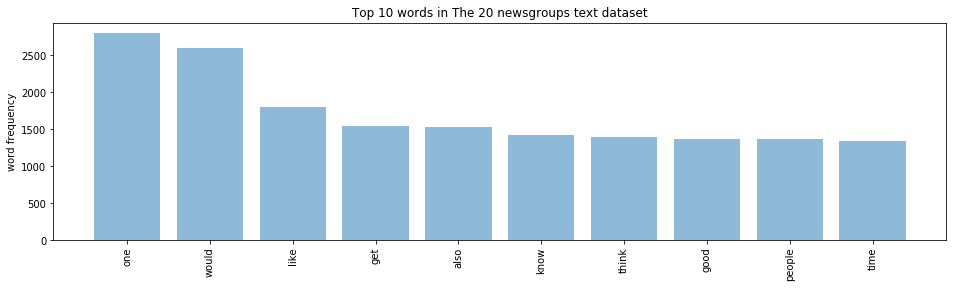

In [44]:
#Plotting top 10 users of Yelp!
x = np.arange(10)
y1 = df_words_data['word_count']
plt.figure(figsize=(16,4))
p1=plt.bar(x, y1, align='center', alpha=0.5)
plt.xticks(x, df_words_data['Feature_name'],rotation='vertical')
plt.ylabel("word frequency")
plt.title("Top 10 words in The 20 newsgroups text dataset")
plt.show()

The graph above shows that word 'one' has more occurence compared to 'would' but overall above words found more often in the text of different newsgroup articles

#### BoW with RandomForest¶

In [15]:
rfc_train = ensemble.RandomForestClassifier()
train = rfc_train.fit(df_newsgroup_train, newsgroups_train.target)

print('Training set score:', rfc_train.score(df_newsgroup_train, newsgroups_train.target))
print('\nTest set score:', rfc_train.score(df_newsgroup_test, newsgroups_test.target))

Training set score: 0.9696861626248217

Test set score: 0.5953912111468381


In [14]:
newsgroups_test.target

array([8, 0, 6, ..., 8, 6, 8])

In [16]:
print(classification_report(newsgroups_test.target, rfc_train.predict(df_newsgroup_test), target_names=newsgroups_test.target_names))

                    precision    recall  f1-score   support

       alt.atheism       0.48      0.54      0.51       319
     comp.graphics       0.56      0.76      0.65       389
         rec.autos       0.45      0.65      0.53       396
   rec.motorcycles       0.62      0.66      0.64       398
rec.sport.baseball       0.66      0.69      0.68       397
  rec.sport.hockey       0.79      0.71      0.74       399
   sci.electronics       0.53      0.43      0.47       393
           sci.med       0.68      0.54      0.60       396
         sci.space       0.73      0.55      0.63       394
talk.religion.misc       0.56      0.32      0.41       251

       avg / total       0.61      0.60      0.59      3732



In [17]:
cross_val_score(rfc_train, df_newsgroup_train, newsgroups_train.target, cv=5)

array([0.62044444, 0.62811388, 0.63190731, 0.63214286, 0.62846911])

#### BoW with Logistic Regression

In [18]:
lr_train = LogisticRegression()
train = lr_train.fit(df_newsgroup_train, newsgroups_train.target)

print('Training set score:', lr_train.score(df_newsgroup_train, newsgroups_train.target))
print('\nTest set score:', lr_train.score(df_newsgroup_test, newsgroups_test.target))

Training set score: 0.9698644793152639

Test set score: 0.7087352625937835


In [19]:
print(classification_report(newsgroups_test.target, lr_train.predict(df_newsgroup_test), target_names=newsgroups_test.target_names))

                    precision    recall  f1-score   support

       alt.atheism       0.59      0.52      0.56       319
     comp.graphics       0.74      0.81      0.78       389
         rec.autos       0.69      0.71      0.70       396
   rec.motorcycles       0.73      0.73      0.73       398
rec.sport.baseball       0.60      0.83      0.70       397
  rec.sport.hockey       0.87      0.84      0.85       399
   sci.electronics       0.67      0.62      0.64       393
           sci.med       0.83      0.69      0.75       396
         sci.space       0.77      0.72      0.74       394
talk.religion.misc       0.57      0.50      0.54       251

       avg / total       0.71      0.71      0.71      3732



In [20]:
cross_val_score(lr_train, df_newsgroup_train, newsgroups_train.target, cv=5)

array([0.75022222, 0.73932384, 0.74955437, 0.76875   , 0.7645479 ])

#### BoW with LinearSVC

In [21]:
model_train = LinearSVC()
train = model_train.fit(df_newsgroup_train, newsgroups_train.target)

print('Training set score:', model_train.score(df_newsgroup_train, newsgroups_train.target))
print('\nTest set score:', model_train.score(df_newsgroup_test, newsgroups_test.target))

Training set score: 0.973074179743224

Test set score: 0.655144694533762


In [22]:
cross_val_score(model_train, df_newsgroup_train, newsgroups_train.target, cv=5)

array([0.69155556, 0.68505338, 0.69964349, 0.72053571, 0.6965085 ])

## Tfidf

In [10]:
vectorizer_train = TfidfVectorizer()

#Applying the vectorizer
newsgrp_tfidf_train =vectorizer_train.fit_transform(newsgroups_train.data)
newsgrp_tfidf_test=vectorizer_train.transform(newsgroups_test.data)

In [11]:
tfid_matrix_train = newsgrp_tfidf_train.toarray()
tfid_matrix_test = newsgrp_tfidf_test.toarray()
tfid_vocab_train = vectorizer_train.get_feature_names()
# show document feature vectors
tfid_matrix_train = pd.DataFrame(tfid_matrix_train, columns=tfid_vocab_train)
tfid_matrix_test = pd.DataFrame(tfid_matrix_test, columns=tfid_vocab_train)

#### Tfidf with RandomForest

In [27]:
rfc_train = ensemble.RandomForestClassifier()
train = rfc_train.fit(tfid_matrix_train, newsgroups_train.target)
print('Training set score:', rfc_train.score(tfid_matrix_train, newsgroups_train.target))
print('\nTest set score:', rfc_train.score(tfid_matrix_test, newsgroups_test.target))

Training set score: 0.9696861626248217

Test set score: 0.5956591639871383


In [28]:
cross_val_score(rfc_train, tfid_matrix_train, newsgroups_train.target, cv=5)

array([0.63022222, 0.58718861, 0.59536542, 0.61607143, 0.63115488])

#### Tfidf with Logistic Regression

In [29]:
lr_train = LogisticRegression()
train = lr_train.fit(tfid_matrix_train, newsgroups_train.target)

print('Training set score:', lr_train.score(tfid_matrix_train, newsgroups_train.target))
print('\nTest set score:', lr_train.score(tfid_matrix_test, newsgroups_test.target))

Training set score: 0.9468616262482168

Test set score: 0.755091103965702


In [30]:
cross_val_score(lr_train, tfid_matrix_train, newsgroups_train.target, cv=5)

array([0.79288889, 0.78291815, 0.79233512, 0.80892857, 0.78782453])

#### Tfidf with LinearSVC

In [31]:
model_train = LinearSVC()
train = model_train.fit(tfid_matrix_train, newsgroups_train.target)

print('Training set score:', model_train.score(tfid_matrix_train, newsgroups_train.target))
print('\nTest set score:', model_train.score(tfid_matrix_test, newsgroups_test.target))

Training set score: 0.973074179743224

Test set score: 0.7655412647374062


In [32]:
cross_val_score(model_train, tfid_matrix_train, newsgroups_train.target, cv=5)

array([0.79733333, 0.80427046, 0.8030303 , 0.82053571, 0.81826321])

#### Tfidf with SGDClassifier

In [24]:
clf = linear_model.SGDClassifier()
train = clf.fit(tfid_matrix_train, newsgroups_train.target)

print('Training set score:', clf.score(tfid_matrix_train, newsgroups_train.target))
print('\nTest set score:', clf.score(tfid_matrix_test, newsgroups_test.target))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Training set score: 0.9680813124108416

Test set score: 0.7360664523043944


In [25]:
cross_val_score(clf, tfid_matrix_train, newsgroups_train.target, cv=5)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/s

array([0.78755556, 0.77935943, 0.7798574 , 0.81160714, 0.77529096])

## Tuning best performing model

As Linear Regression seems working well with bag of words so lets tunned the model to check if that improves the performance the model.
Lets tunned the model with bag of words as well as tfidf vectors for LogisticRegression

In [35]:
# A parameter grid for LogisticRegression with BoW vectors
params = {'C':[1,10], 'penalty':['l1','l2']}
lr = LogisticRegression()

# Initialize LogisticRegression and GridSearch
grid = GridSearchCV(lr, params, cv=3)
grid.fit(df_newsgroup_train, newsgroups_train.target)
best_lr = grid.best_estimator_
score = accuracy_score(y_true=newsgroups_test.target, y_pred=best_lr.predict(df_newsgroup_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.7087



In [19]:
# A parameter grid for LinearSVC  with tfidf vectors
params = {'C':[1,10]}
svc = LinearSVC()

# Initialize LogisticRegression and GridSearch
grid_tfidf_svc = GridSearchCV(svc, params, cv=3)
grid_tfidf_svc.fit(tfid_matrix_train, newsgroups_train.target)
best_svc = grid_tfidf_svc.best_estimator_
score = accuracy_score(y_true=newsgroups_test.target, y_pred=best_svc.predict(tfid_matrix_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.7655



In [20]:
# A parameter grid for LogisticRegression  with tfidf vectors
params = {'C':[1,10], 'penalty':['l1','l2']}
lr = LogisticRegression()

# Initialize LogisticRegression and GridSearch
grid_tfidf = GridSearchCV(lr, params, cv=3)
grid_tfidf.fit(tfid_matrix_train, newsgroups_train.target)
best_lr = grid_tfidf.best_estimator_
score = accuracy_score(y_true=newsgroups_test.target, y_pred=best_lr.predict(tfid_matrix_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.7666



In [16]:
grid_tfidf.best_params_

{'C': 10, 'penalty': 'l2'}

In [15]:
# cross_val_score
cross_val_score(best_lr, df_newsgroup_train, newsgroups_train.target, cv=5)

array([0.73422222, 0.72597865, 0.73885918, 0.75892857, 0.74127126])

## Dimension Reduction with SVD

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

cv =  CountVectorizer(min_df = 0.001, max_df = 0.98)
cv_matrix_train = cv.fit_transform(newsgroups_train.data)
cv_matrix_train = cv_matrix_train.toarray()

In [87]:
cv_matrix_test = cv.transform(newsgroups_test.data)
cv_matrix_test = cv_matrix_test.toarray()

In [88]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
df_newsgroup_train_lsa = pd.DataFrame(cv_matrix_train, columns=vocab)
df_newsgroup_test_lsa = pd.DataFrame(cv_matrix_test, columns=vocab)

In [90]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 48369 to 130.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
Data_lsa_train= lsa.fit_transform(df_newsgroup_train_lsa)
Data_lsa_test= lsa.transform(df_newsgroup_test_lsa)
# Split training testing data
#X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(df_newsgroup_train_lsa, newsgroups_train.target, random_state=3)

So the result of logistic regression model before applying SVD is as follows

In [94]:
lr = LogisticRegression()
train = lr.fit(df_newsgroup_train_lsa, newsgroups_train.target)
print('Training set score:', lr.score(df_newsgroup_train_lsa,  newsgroups_train.target))
print('\nTest set score:', lr.score(df_newsgroup_test_lsa, newsgroups_test.target))

Training set score: 0.9662981455064193

Test set score: 0.7004287245444801


The result of logistic regression model afer applying SVD is as follows

In [95]:
lr = LogisticRegression()
train = lr.fit(Data_lsa_train, newsgroups_train.target)
print('Training set score:', lr.score(Data_lsa_train, newsgroups_train.target))
print('\nTest set score:', lr.score(Data_lsa_test, newsgroups_test.target))

Training set score: 0.8443295292439372

Test set score: 0.702572347266881


The above analysis shows that the model is improved after applying SVD to the data and also noise is removed as before the data was overfitting with more noise . Lets try LinearSVC after SVD with tfidf vectors as it was giving better performance before

In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 48369 to 130.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
Data_lsa_train= lsa.fit_transform(tfid_matrix_train)
Data_lsa_test= lsa.transform(tfid_matrix_test)

In [18]:
model_train = LinearSVC()
train = model_train.fit(Data_lsa_train, newsgroups_train.target)

print('Training set score:', model_train.score(Data_lsa_train, newsgroups_train.target))
print('\nTest set score:', model_train.score(Data_lsa_test, newsgroups_test.target))

Training set score: 0.9538159771754636

Test set score: 0.7387459807073955


### K-Means

Lets do some unsupervised learnings on data to get some patterns of data. Lets try Kmeans to check to unsupervised clustering of data. Initially lets generate 4 clusters and check what are the differe t data clusters we will be getting

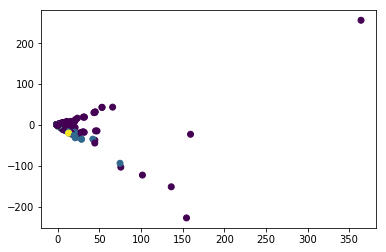

In [97]:
X_pca = PCA(2).fit_transform(df_newsgroup_train)

# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(Data_lsa_train)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [28]:
label_name = newsgroups_train.target_names

In [106]:
df1 = pd.DataFrame()
df1['cluster_labels'] = y_pred
df1['target_labels'] = [label_name[item] for item in newsgroups_train.target]
df1.groupby(['cluster_labels','target_labels']).size()

cluster_labels  target_labels     
0               alt.atheism           262
                comp.graphics         299
                rec.autos             341
                rec.motorcycles       359
                rec.sport.baseball    403
                rec.sport.hockey      378
                sci.electronics       290
                sci.med               346
                sci.space             357
                talk.religion.misc    229
1               alt.atheism           124
                comp.graphics          46
                rec.autos              83
                rec.motorcycles       118
                rec.sport.baseball     85
                rec.sport.hockey       96
                sci.electronics       102
                sci.med               120
                sci.space              70
                talk.religion.misc     82
2               alt.atheism            66
                comp.graphics          75
                rec.autos              89

If we choose to generate 4 clusters then we see that 
- cluster 3 is more of graphics and electronics related articles.
- cluster 2 is more of space related articles. 
- cluster 1 is more of atheism, med and motorcycles related articles.

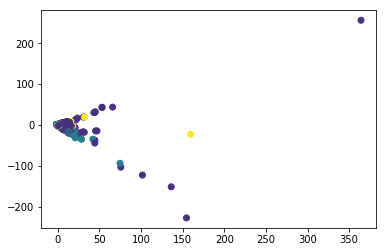

In [107]:
X_pca = PCA(2).fit_transform(df_newsgroup_train)

# Calculate predicted values.
y_pred = KMeans(n_clusters=8, random_state=42).fit_predict(Data_lsa_train)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [112]:
df = pd.DataFrame()
df['cluster_labels'] = y_pred
df['target_labels'] = [label_name[item] for item in newsgroups_train.target]
myDF = pd.DataFrame(df.groupby(['cluster_labels','target_labels']).size())

In [114]:
with pd.option_context("display.max_rows", 1000): print(myDF)

                                     0
cluster_labels target_labels          
0              alt.atheism          27
               comp.graphics        76
               rec.autos            45
               rec.motorcycles      36
               rec.sport.baseball   24
               rec.sport.hockey     21
               sci.electronics      52
               sci.med              45
               sci.space            39
               talk.religion.misc   21
1              alt.atheism         227
               comp.graphics       279
               rec.autos           261
               rec.motorcycles     272
               rec.sport.baseball  196
               rec.sport.hockey    160
               sci.electronics     255
               sci.med             232
               sci.space           287
               talk.religion.misc  210
2              alt.atheism          26
               comp.graphics        32
               rec.autos            76
               rec.motorc

If we choose 8 clusters then 
- It seems like all the clusters have lot of noise except cluster 7 which shows articles which are more related to sports like hockey and baseball 
- Most of the clusters are not showing any pattern of data

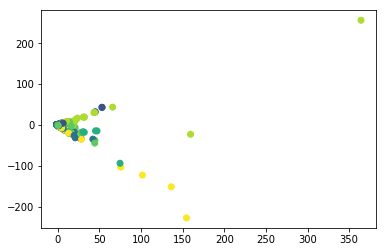

In [26]:
X_pca = PCA(2).fit_transform(df_newsgroup_train)

# Calculate predicted values.
y_pred = KMeans(n_clusters=9, random_state=42).fit_predict(Data_lsa_train)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [29]:
df = pd.DataFrame()
df['cluster_labels'] = y_pred
df['target_labels'] = [label_name[item] for item in newsgroups_train.target]
myDF = pd.DataFrame(df.groupby(['cluster_labels','target_labels']).size())

In [30]:
with pd.option_context("display.max_rows", 1000): print(myDF)

                                     0
cluster_labels target_labels          
0              rec.motorcycles     162
1              alt.atheism           3
               rec.autos           194
               rec.motorcycles      16
               rec.sport.hockey      1
               sci.electronics      11
               sci.space             1
               talk.religion.misc    1
2              alt.atheism         170
               comp.graphics       162
               rec.autos           199
               rec.motorcycles     234
               rec.sport.baseball  259
               rec.sport.hockey    167
               sci.electronics     220
               sci.med             177
               sci.space           190
               talk.religion.misc  162
3              alt.atheism         234
               rec.autos             4
               rec.motorcycles       2
               rec.sport.baseball    2
               rec.sport.hockey      1
               sci.electr

If we choose to generate 9 clusters then
- cluster 0 shows 
- cluster 1 shows more articles related to motorcycles and autos which are more of vehicles
- cluster 3 shows more articles related to atheism as well as religion.misc which are more of religious
- cluster 6 is more related to space
- cluster 8 is more of graphics and sci.electronics related articles

## Conclusions

As we have performed both supervised and unsupervised learning on the dataset, we can conclude following
- As the datatset is labelled so supervised learning gives best results while classifying this text
- supervised learning helps to predict data while unsupervised helps to find out some patterns in the dataset like here what kind of newsgroup data comes together to create one cluster so they seems to be related to each other
- We will be going for supervised learning here as it gives good results compared to unsupervised learnings which does not give very well defined clusters and includes lot of noise compared to other
- Logistic Regression with tfidf feature creation method after performance tuning gave best results 
- SVD helped to reduce overfitting in case of Logistic Regression